- 아이템 간 연간 관계를 수치화하고 이를 이용한 추천 시스템을 구현합니다.

In [6]:
import requests
from io import BytesIO
from PIL import Image
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_file
import scipy
from tqdm.notebook import tqdm
from itertools import combinations
import mlxtend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import pickle as pk
from google_drive_downloader import GoogleDriveDownloader as gdd

plt.style.use("dark_background")

In [63]:
def display_poster(if_item, then_item):
    def get_poster(movie_id):
        url = f"https://pai-datasets.s3.ap-northeast-2.amazonaws.com/recommender_systems/movielens/img/POSTER_20M_FULL/{movie_id}.jpg"
        try:
            req = requests.get(url)
            b = BytesIO(req.content)
            img = np.asarray(Image.open(b))
        except:
            img = np.zeros((200, 100, 3))
        return img
    
    def get_movie_title(movie_id):
        global movies_df
        return movies_df.loc[movies_df["id"]==movie_id, "title"].iloc[0]
    
    if_image = get_poster(list(if_item)[0])
    if_title = get_movie_title(list(if_item)[0])
    then_image = get_poster(list(then_item)[0])
    then_title = get_movie_title(list(then_item)[0])

    fig = plt.figure(figsize=(8, 8))
    fig.set_size_inches((20, 5))    
    
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title(f"[antecedent]{if_title}")
    ax.imshow(if_image)

    ax = fig.add_subplot(1, 2, 2)
    ax.set_title(f"[consequent]{then_title}")
    ax.imshow(then_image)   
    
    plt.tight_layout()  

In [38]:
gdd.download_file_from_google_drive(file_id="1uPjBuhv96mJP9oFi-KNyVzNkSlS7U2xY", dest_path="./movies.csv")
movies_df = pd.read_csv("movies.csv", index_col=0)

gdd.download_file_from_google_drive(file_id="1hik_RSV0e5r_P3iYe4sK8B-eNWxmIWOa", dest_path="./genres.csv")
genres_df = pd.read_csv("genres.csv", index_col=0)

gdd.download_file_from_google_drive(file_id="15vsm-VWAC3Y-7jr7ROL_xy0ufkIfqSke", dest_path="./ratings.csv")
ratings_df = pd.read_csv("ratings.csv", index_col=0)

C:\Users\5CG7092POZ\Anaconda3\envs\tf2.0\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# 연관 분석(Association Analysis)
- 대용량의 거래(transaction) 데이터로부터 "X를 구매했으면, Y를 구매할 것이다" 형식의 아이템 간 연관 관계를 분석하는 방법입니다.
- 보통 장바구니 분석(Market Basket Analysis)로 불리기도 합니다. 즉, 고객의 장바구니에 어떤 아이템이 동시 담겼는지 패턴을 파악하여 상품을 추천하는 방법입니다.

## 연관 분석의 주요 지표
- 크게 support, confidence, lift라는 세 가지 지표를 통해 아이템 간의 관계를 표현합니다.

### Support
- `sup(x) = like(x)/N`
- 전체 사용자 중에서 아이템 x를 좋아하는 사용자의 비율

### Confidence
- `conf(x, y) = like(x, y)/like(x) = sup(x, y)/sup(x) != conf(y, x)`
- 아이템 x를 좋아하는 사용자 중에서 아이템 y도 좋아하는 사람의 비율

### lift
- `lift(x, y) = conf(x, y)/sup(y) = sup(x, y)/(sup(x)*sup(y)) = lift(y, x)`
- 전체 사용자들 중 아이템 y를 좋아하는 비율(support)보다 아이템 x를 좋아하는 사용자들 중 아이템 y도 좋아하는 비율(confidence)가 매우 크다면 아이템 x와 y는 매우 연관 관계가 높을 것입니다.
- 반면에 전체 사용자들 중 아이템 y를 좋아하는 비율(support)보다 아이템 x를 좋아하는 사용자들 중 아이템 y도 좋아하는 비율(confidence)이 매우 작다면 아이템 x와 y는 매우 연관 관계가 낮을 것입니다.
- lift의 의미는 어떤 사용자가 아이템 x를 좋아한다는 사실이 아이템 y를 좋아할 가능성이 높인다는 의미입니다.

In [41]:
#support, confidence, lift를 계산하는 함수를 각각 만듭니다.
def calc_sup(x):
    likes = baskets[x <= baskets].index
    all_users = set(ratings_df["user_id"])
    return len(likes)/len(all_users)

def calc_conf(x, y):
    likes_x = baskets[x <= baskets].index
    likes_xy = baskets[x|y <= baskets].index
    return len(likes_xy)/len(likes_x)

def calc_lift(x, y):
    return calc_conf(x, y)/calc_sup(y)

In [23]:
print(f"전체 사용자들 중 타이타닉을 좋아하는 사용자의 비율 : {calc_sup({1721}):.3f}")
print(f"스타워즈2를 좋아하는 사용자들 중 타이타닉도 좋아하는 사용자의 비율 : {calc_conf({5378}, {1721}):.3f}")
print(f"스타워즈2를 좋아하는 사용자들 중 스타워즈3도 좋아하는 사용자의 비율 : {calc_conf({5378}, {33493}):.3f}")
print(f"스타워즈2와 타이타닉의 lift : {calc_lift({5378}, {1721}):.3f}")
print(f"스타워즈2와 스타워즈3의 lift : {calc_lift({5378}, {33493}):.3f}")

전체 사용자들 중 타이타닉을 좋아하는 사용자의 비율 : 0.100
스타워즈2를 좋아하는 사용자들 중 타이타닉도 좋아하는 사용자의 비율 : 0.290
스타워즈2를 좋아하는 사용자들 중 스타워즈3도 좋아하는 사용자의 비율 : 0.502
스타워즈2와 타이타닉의 lift : 2.894
스타워즈2와 스타워즈3의 lift : 12.215


# 세 지표를 활용한 추천 알고리즘
1. support와 confidence의 최소 기준을 정하여 그 기준에 미달하는 연관 관계를 제거합니다. support와 confidence가 너무 작으면 lift의 의미가 왜곡되어 해석될 수 있기 때문입니다.
2. lift를 기준으로 연관 관계가 강한 아이템들을 추천합니다.

## 빈발 집합(Frequent Set)
- 빈번하게 등장한 아이템의 쌍을 빈발집합이라고 합니다.
- 연관 분석을 실무에 적용하면, 어떤 아이템 x를 좋아하는 사용자에게 다른 아이템을 추천하기 위해 lift 값을 계산하는 무수히 많은 연산을 수행해야 합니다.
- 이를 해결하기 위한 빈발집합 탐색 알고리즘은 자주 등장하는 아이템의 쌍만을 탐색합니다.
- 대표적으로 Apriori와 Frequent Pattern Growth가 있으며 후자가 전자보다 빠르지만 산출 결과는 동일합니다.

# Apriori Algorithm
- 어떤 아이템 a, b를 모두 좋아하는 사용자의 수가 적다면 sup(a, b)의 값은 작을 것입니다.
- 그렇다면 a, b, c를 모두 좋아하는 사용자의 수는 더 적을 것이므로 sup(a, b, c)는 sup(a, b)보다 작을 것입니다.
- 이때 Apriori Algorithm은 a, b가 모두 포함된 모든 집합에 대해 support를 계산하지 않는 방식으로 연산 부하를 줄입니다.
- 전체 데이터에 대해 빈발집합 탐색 알고리즘을 사용하면 시간이 너무 오래 걸리므로 2015년 기준 10년 내 개봉한 영화만을 고려하도록 합니다.

In [65]:
#평점을 4점 이상 준 영화를 좋아한다고 판단하겠습니다.
likes_df = ratings_df[ratings_df["rating"]>=4.0]

#최근 10년 내 영화만 선별합니다.
recent_yr = movies_df["release_year"].max()
recent_movies = movies_df[movies_df["release_year"].isin(range(recent_yr, recent_yr-10, -1))]["id"]

likes_df_recent = likes_df[likes_df["movie_id"].isin(recent_movies)]

In [67]:
print(f"샘플 갯수 : {len(likes_df)} -> {len(likes_df_recent)}({len(ratings_df_recent)/len(ratings_df):.1%})")

샘플 갯수 : 9995410 -> 815841(8.4%)


## 1. 직접 구현하기(전체 연산이 매우 오래 걸리므로 비추)

In [46]:
max_len = 3
min_sup = 0.01

freq_sets = {frozenset((movie, )) for movie in ratings_df["movie_id"]}

freq_set2sup = {}
for i in range(1, max_len+1):
    #i개 원소를 갖는 frozenset만을 고려합니다.
    freq_sets = list(filter(lambda x : len(x) == i, freq_sets))
    
    #frozsenset:support를 dictionary로 저장합니다.
    freq_set2sup_temp = {}    
    for freq_set in tqdm(freq_sets):
        sup = round(calc_sup(freq_set), 3)
        #min_sup보다 support가 높은 frozenset만을 선별합니다.
        if sup >= min_sup:
            freq_set2sup_temp[freq_set] = sup
            print(freq_set, sup)
            
    freq_set2sup.update(freq_set2sup_temp)
    #원소 2개의 조합으로 만들 수 있는 모든 합집합을 만듭니다.
    freq_sets = {a | b for a, b in combinations(freq_set2sup.keys(), 2)}

frozenset({88129}) 0.013
frozenset({2357}) 0.013



KeyboardInterrupt: 

## 2. Mlxtend Library로 구현하기

In [68]:
likes_df_recent

user_id  movie_id  rating    rated_at
1314           11     27904     5.0  1230788788
1354           11     43556     5.0  1230785199
1359           11     44191     4.0  1251170242
1361           11     44731     5.0  1251170347
1363           11     44849     4.5  1230788771
...           ...       ...     ...         ...
20000256   138493     66762     4.5  1255805408
20000257   138493     68319     4.5  1260209720
20000258   138493     68954     4.5  1258126920
20000259   138493     69526     4.5  1259865108
20000261   138493     70286     5.0  1258126944

[815841 rows x 4 columns]

In [69]:
#사용자별로 좋아하는 최신 영화의 집합을 만듭니다.
baskets = likes_df_recent.groupby("user_id")["movie_id"].apply(set)

#각 영화를 좋아하는지 여부를 dataframe 형태로 만드는 multi-hot encoding을 수행합니다.
te = TransactionEncoder()
baskets_te = te.fit_transform(baskets)

baskets_df = pd.DataFrame(baskets_te, index=baskets.index, columns=te.columns_)

In [97]:
baskets_df.sample(5)

27904   38188   41863   42725   42728   42730   42732   42738   \
user_id                                                                   
70010     False   False   False   False   False   False   False   False   
95895     False   False   False   False   False   False   False   False   
109985    False   False   False   False   False   False   False   False   
101166    False   False   False   False   False   False   False   False   
6609      False   False   False   False   False   False   False   False   

         43391   43419   ...  131148  131150  131160  131164  131166  131176  \
user_id                  ...                                                   
70010     False   False  ...   False   False   False   False   False   False   
95895     False   False  ...   False   False   False   False   False   False   
109985    False   False  ...   False   False   False   False   False   False   
101166    False   False  ...   False   False   False   False   False   False   
6609      False   False  ...   False   False   False   False   False   False   

         131239  131248  131254  131262  
user_id                                  
70010     False   False   False   False  
95895     False   False   False   False  
109985    False   False   False   False  
101166    False   False   False   False  
6609      False   False   False   False  

[5 rows x 6407 columns]

In [75]:
#freq_sets_df.pkl이 있으면 불러오고 없으면 산출 후 저장합니다.
file = "freq_sets_df.pkl"
if os.path.exists(file):
    with open(file, "rb") as f:
        freq_sets_df = pk.load(f)
else:
    with open(file, "wb") as f:
        #max_len을 3이상으로 할 시 매우 많은 메모리가 필요합니다.
        freq_sets_df = apriori(baskets_df.sample(frac=0.05), min_support=0.01, max_len=2, use_colnames=True, verbose=1)
        
        pk.dump(freq_sets_df, f)

Processing 107912 combinations | Sampling itemset size 2


In [99]:
freq_sets_df

support          itemsets
0     0.030631           (27904)
1     0.011261           (42725)
2     0.017568           (42738)
3     0.012613           (43936)
4     0.019820           (44022)
...        ...               ...
4385  0.010811   (99114, 106782)
4386  0.010811   (99114, 109374)
4387  0.010811   (99114, 109487)
4388  0.010811   (99114, 112556)
4389  0.010811  (112852, 109487)

[4390 rows x 2 columns]

## 3. 연관 분석 수행하기

In [77]:
#support>0.01인 경우만 선별합니다.
asso_rules = association_rules(freq_sets_df, metric="support", min_threshold=0.01)
#confidence>0.1인 경우만 선별합니다.
asso_rules = asso_rules[asso_rules["confidence"]>0.1]
asso_rules = asso_rules.sort_values("lift", ascending=False)

In [78]:
#movie_id:title의 dictionary
id2title = dict(zip(movies_df["id"], movies_df["title"]))

#영화 제목을 column으로 추가합니다.
asso_rules.insert(2, "antecedents_title", asso_rules["antecedents"].apply(lambda x : id2title[list(x)[0]]))
asso_rules.insert(3, "consequents_title", asso_rules["consequents"].apply(lambda x : id2title[list(x)[0]]))

In [96]:
asso_rules.iloc[:40:2]

antecedents consequents                             antecedents_title  \
8107    (106489)     (98809)          Hobbit: The Desolation of Smaug, The   
7910     (88140)     (86332)            Captain America: The First Avenger   
8121    (109487)    (112852)                                  Interstellar   
3877     (53519)     (54995)                                   Death Proof   
3668     (52281)     (54995)                                    Grindhouse   
8035    (106487)     (91500)              Hunger Games: Catching Fire, The   
8090    (102445)     (96079)                       Star Trek Into Darkness   
8072     (91630)     (96079)          Mission: Impossible - Ghost Protocol   
8096     (97304)     (97921)                                          Argo   
7511     (86332)     (77561)                                          Thor   
7921     (88140)     (87232)            Captain America: The First Avenger   
7942     (87232)    (110102)                            X-Men: First Class   
8070     (98809)     (91542)            Hobbit: An Unexpected Journey, The   
8075     (91658)     (97921)              Girl with the Dragon Tattoo, The   
5495     (67087)     (58998)                               I Love You, Man   
8009    (102125)     (89745)                                    Iron Man 3   
3662     (52281)     (53519)                                    Grindhouse   
7825     (88125)     (81834)  Harry Potter and the Deathly Hallows: Part 2   
7906     (87232)     (86332)                            X-Men: First Class   
7516     (77561)     (88140)                                    Iron Man 2   

                                 consequents_title  antecedent support  \
8107            Hobbit: An Unexpected Journey, The            0.018468   
7910                                          Thor            0.024775   
8121                       Guardians of the Galaxy            0.026577   
3877                                 Planet Terror            0.026577   
3668                                 Planet Terror            0.042342   
8035                             Hunger Games, The            0.022072   
8090                                       Skyfall            0.024324   
8072                                       Skyfall            0.021171   
8096                       Silver Linings Playbook            0.033333   
7511                                    Iron Man 2            0.025225   
7921                            X-Men: First Class            0.024775   
7942           Captain America: The Winter Soldier            0.048198   
8070            Sherlock Holmes: A Game of Shadows            0.032883   
8075                       Silver Linings Playbook            0.030631   
5495                     Forgetting Sarah Marshall            0.022072   
8009                                 Avengers, The            0.014414   
3662                                   Death Proof            0.042342   
7825  Harry Potter and the Deathly Hallows: Part 1            0.056757   
7906                                          Thor            0.048198   
7516            Captain America: The First Avenger            0.036036   

      consequent support   support  confidence       lift  leverage  \
8107            0.032883  0.013514    0.731707  22.251921  0.012906   
7910            0.025225  0.013514    0.545455  21.623377  0.012889   
8121            0.020721  0.010811    0.406780  19.631540  0.010260   
3877            0.022973  0.010360    0.389831  16.969093  0.009750   
3668            0.022973  0.014865    0.351064  15.281602  0.013892   
8035            0.038288  0.012613    0.571429  14.924370  0.011768   
8090            0.035586  0.012613    0.518519  14.571027  0.011747   
8072            0.035586  0.010360    0.489362  13.751683  0.009607   
8096            0.027027  0.012162    0.364865  13.500000  0.011261   
7511            0.036036  0.012162    0.482143  13.379464  0.011253   
7921            0.048198  0.01

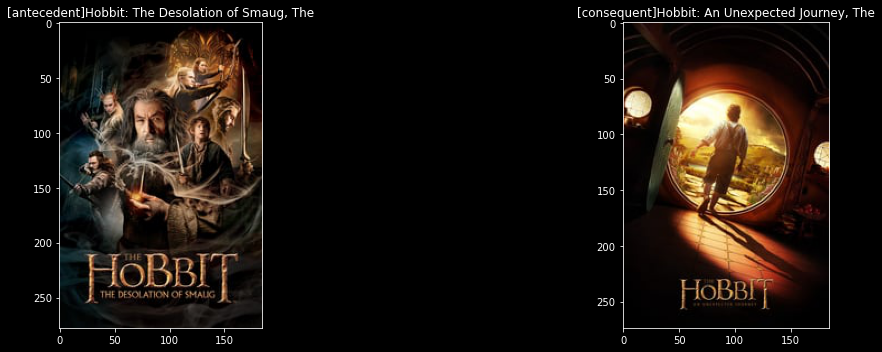

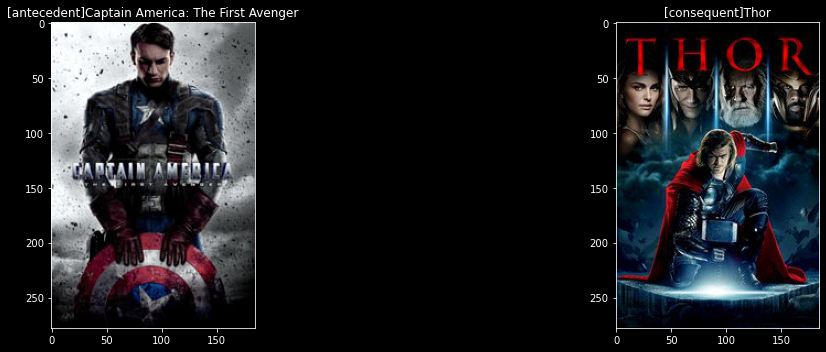

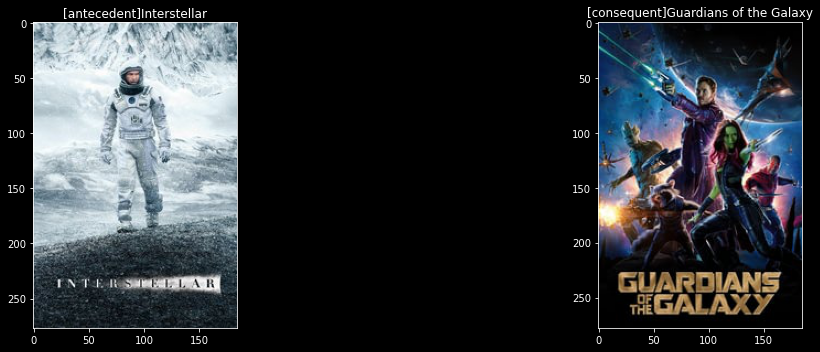

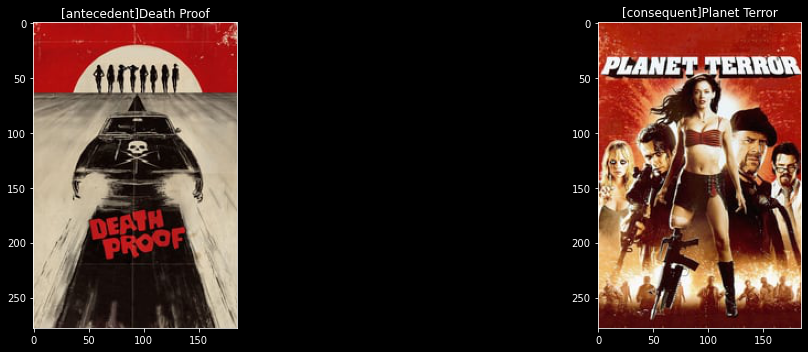

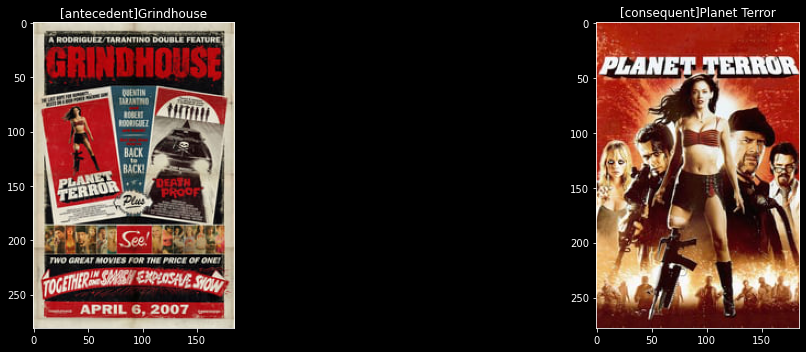

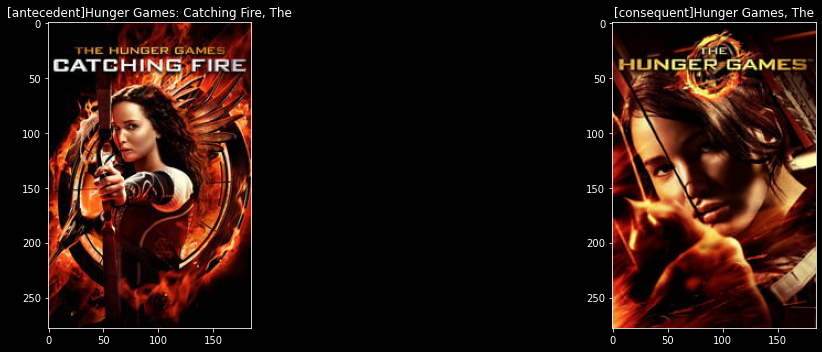

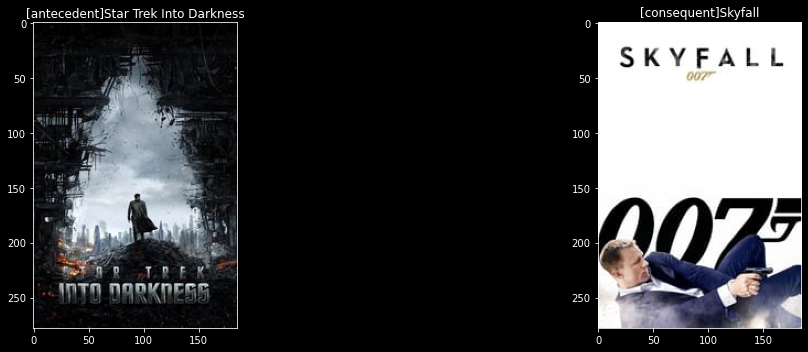

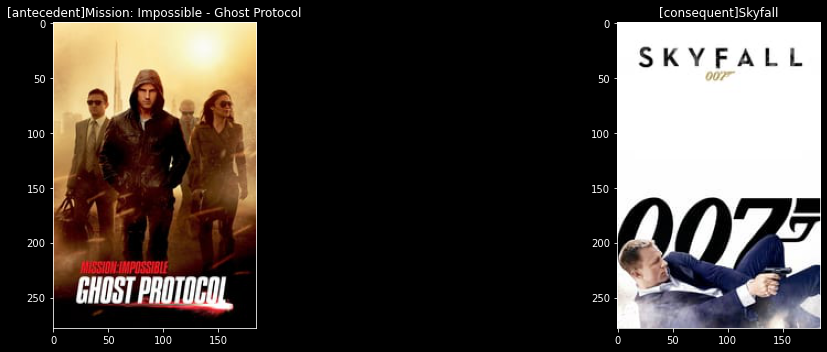

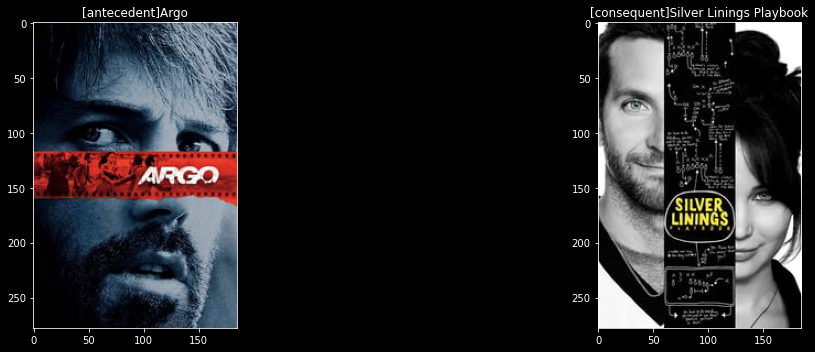

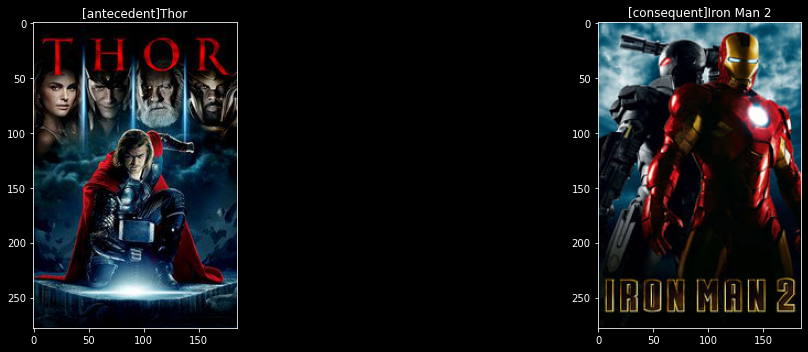

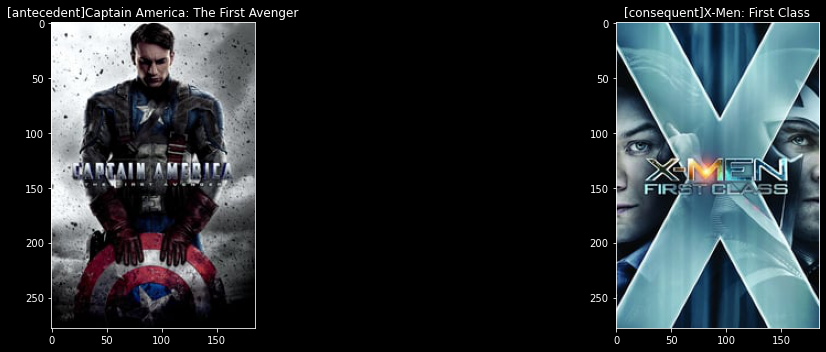

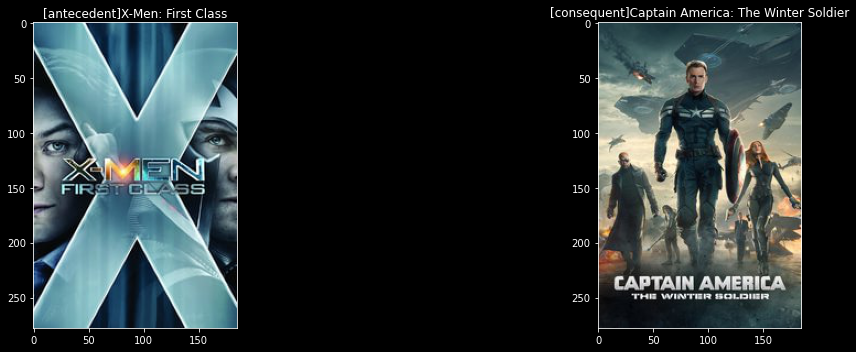

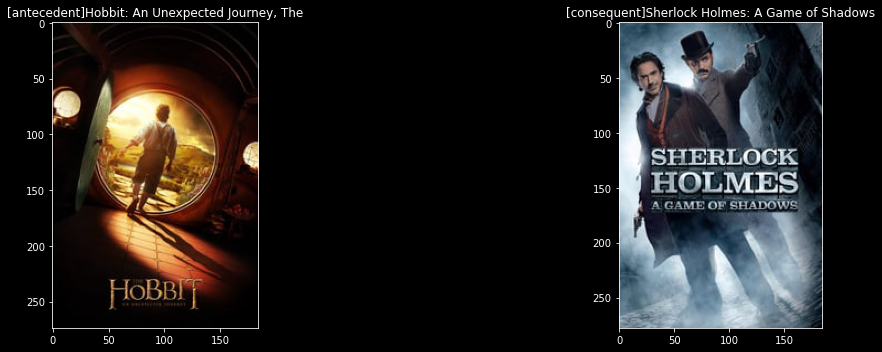

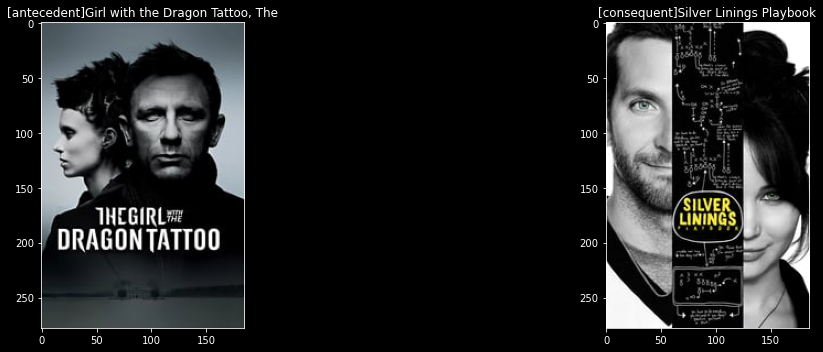

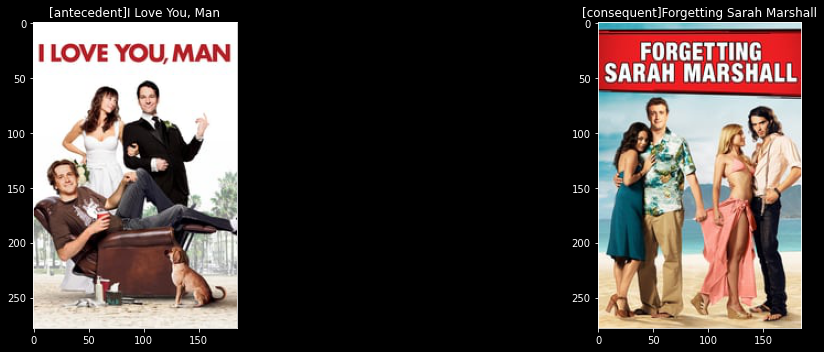

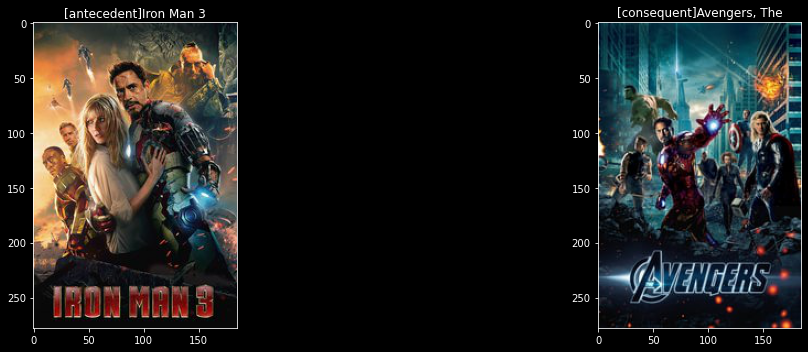

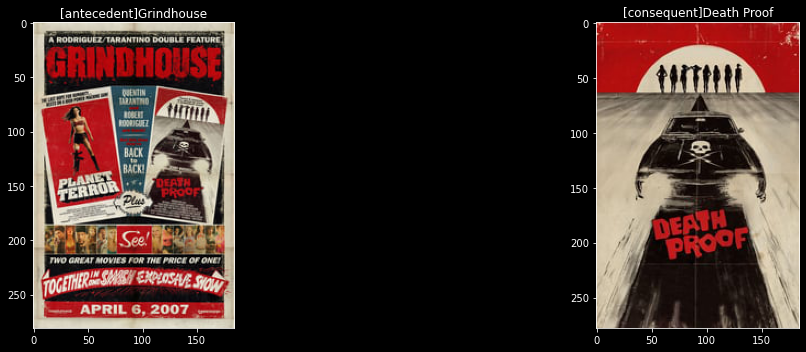

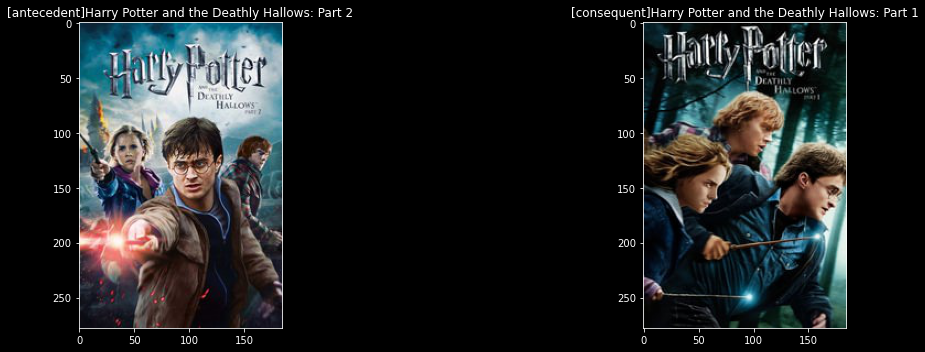

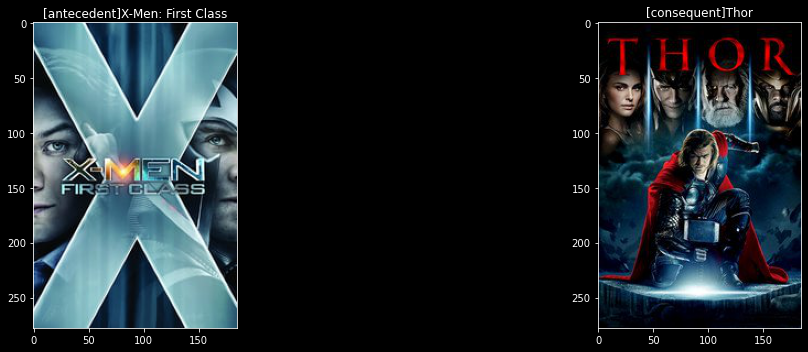

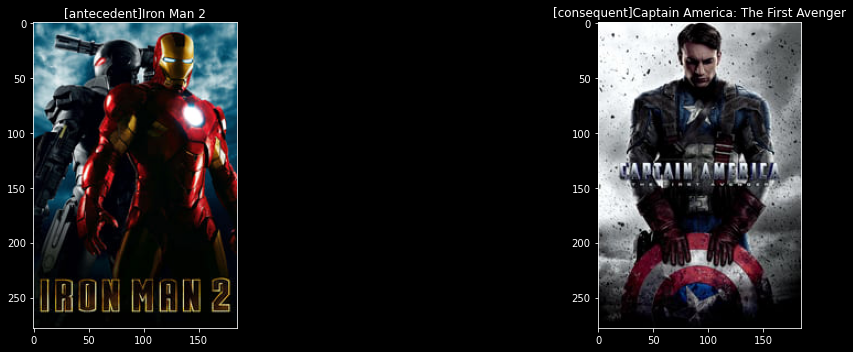

In [91]:
for _, row in asso_rules.iloc[:40:2].iterrows():
    display_poster(row["antecedents"], row["consequents"])